In [2]:
# Importing TensorFlow libraries
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,LSTM,MaxPooling2D,GlobalAveragePooling2D,Dense,Input,Dropout,Flatten,concatenate,AveragePooling2D,BatchNormalization,MaxPool2D,TimeDistributed
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [3]:
print(os.listdir('archive'))

['test', 'train']


In [4]:
train_dir = "archive/train" 
test_dir = "archive/test"   

In [5]:
emotion_labels = sorted(os.listdir(train_dir))
print(emotion_labels)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
emotion_labels = sorted(os.listdir(test_dir))
print(emotion_labels)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [34]:
# Data visualisation
emotions = os.listdir(train_dir)
for emotion in emotions:
    count = len(os.listdir(f'archive/train/{emotion}'))
    print(f'{emotion} faces={count}')

angry faces=3995
disgust faces=436
fear faces=4097
happy faces=7215
neutral faces=4965
sad faces=4830
surprise faces=3171


In [35]:
# Data visualisation
emotions = os.listdir(test_dir)
for emotion in emotions:
    count = len(os.listdir(f'archive/test/{emotion}'))
    print(f'{emotion} faces={count}')

angry faces=958
disgust faces=111
fear faces=1024
happy faces=1774
neutral faces=1233
sad faces=1247
surprise faces=831


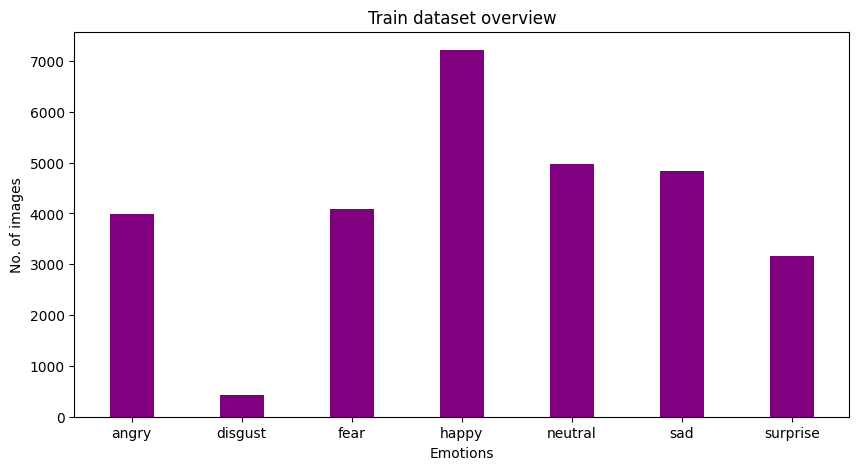

In [36]:
# Data visualisation
emotions = os.listdir(train_dir)
values = [len(os.listdir(f'archive/train/{emotion}')) for emotion in emotions]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(emotions, values, color ='purple',
        width = 0.4)

plt.xlabel("Emotions")
plt.ylabel("No. of images")
plt.title("Train dataset overview")
plt.show()

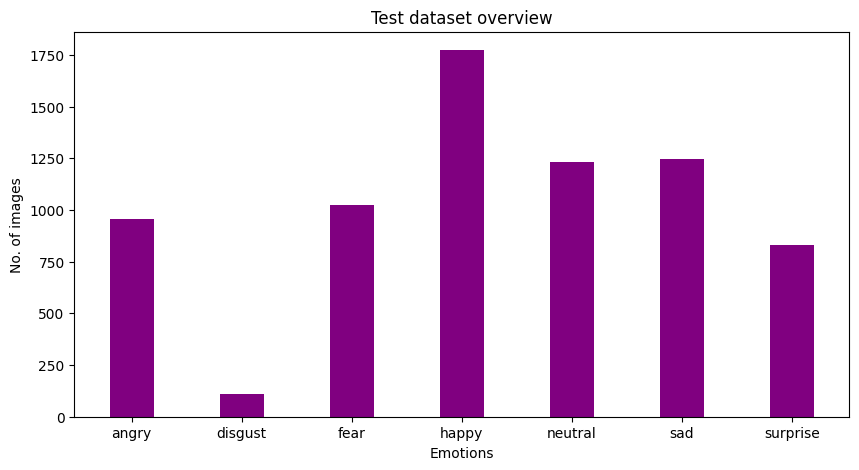

In [39]:
# Data visualisation
emotions = os.listdir(test_dir)
values = [len(os.listdir(f'archive/test/{emotion}')) for emotion in emotions]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(emotions, values, color ='purple',
        width = 0.4)

plt.xlabel("Emotions")
plt.ylabel("No. of images")
plt.title("Test dataset overview")
plt.show()

In [40]:
def plot_images(img_dir, top=10):

  all_img_dirs = os.listdir(img_dir)
  img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:top]

  plt.figure(figsize=(12, 12))

  # Move tight layout outside the loop for efficiency
  plt.tight_layout()

  for idx, img_path in enumerate(img_files):
    plt.subplot(5, 5, idx+1)
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')

Angry: 



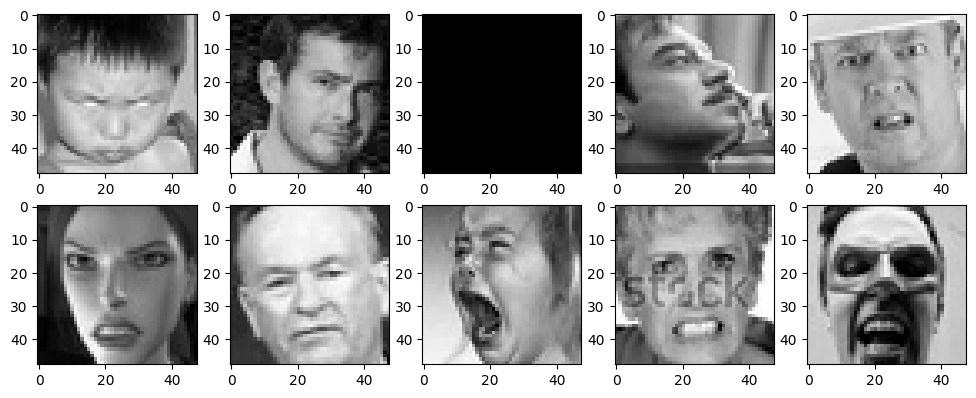

In [42]:
print('Angry: ')
print()
plot_images(train_dir+'/angry')

Happy: 



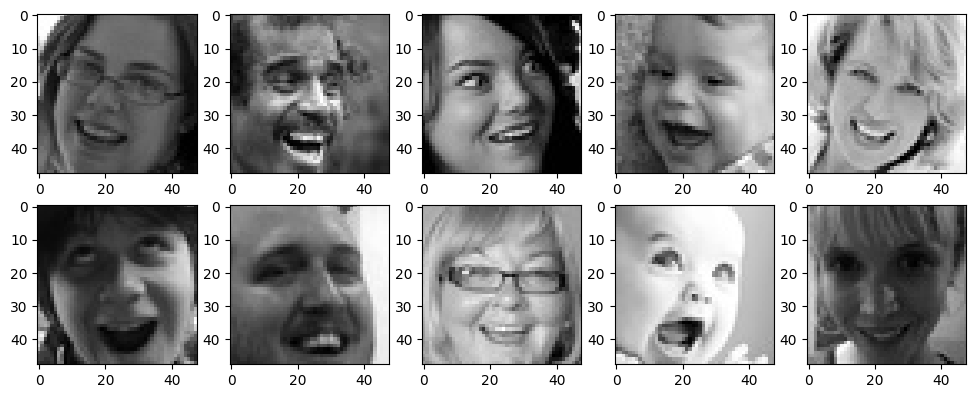

In [43]:
print('Happy: ')
print()
plot_images(train_dir+'/happy')

Sad: 



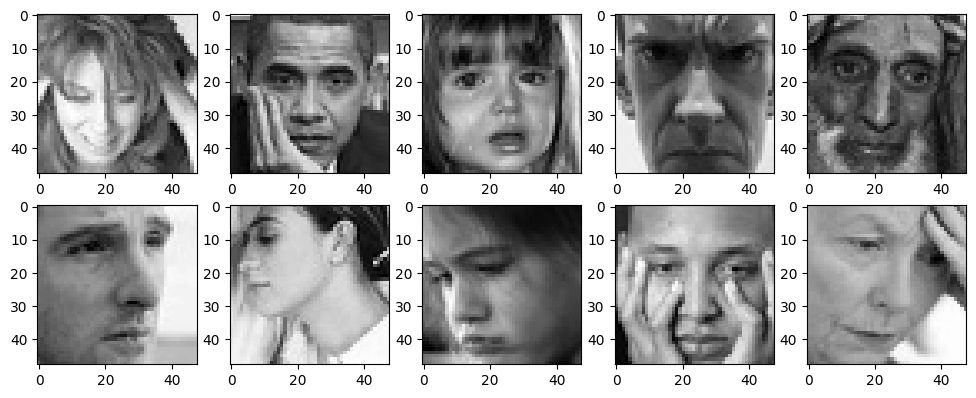

In [44]:
print('Sad: ')
print()
plot_images(train_dir+'/sad')

Fear: 



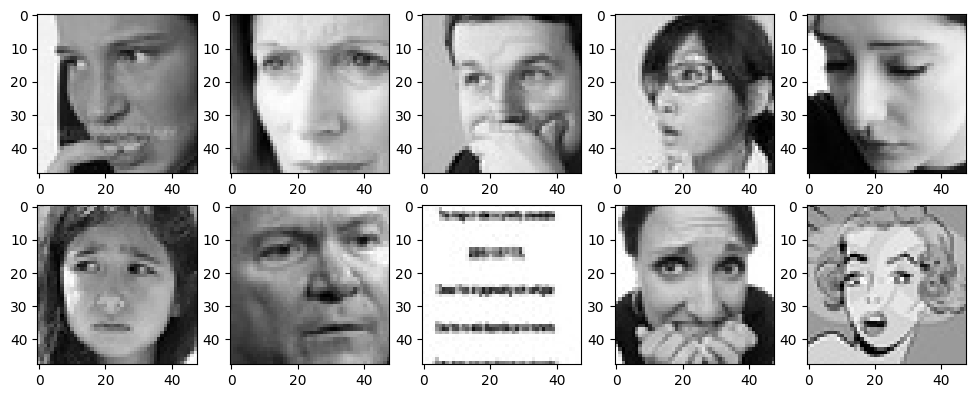

In [45]:
print('Fear: ')
print()
plot_images(train_dir+'/fear')

Neutral: 



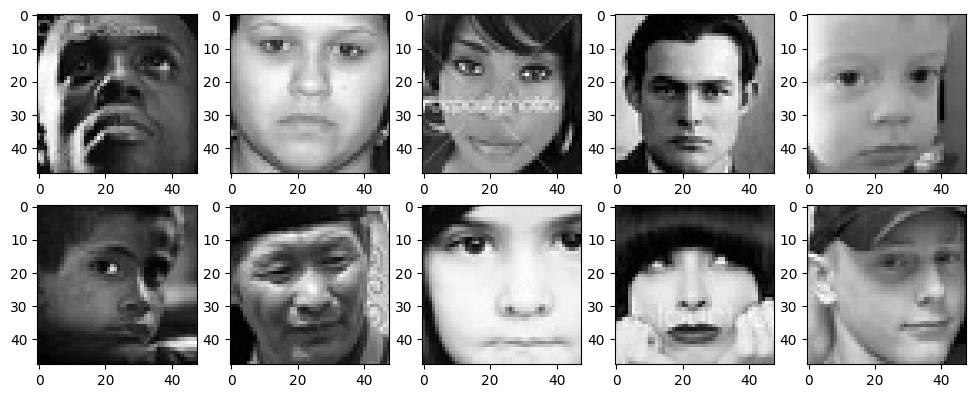

In [46]:
print('Neutral: ')
print()
plot_images(train_dir+'/neutral')

Disgust: 



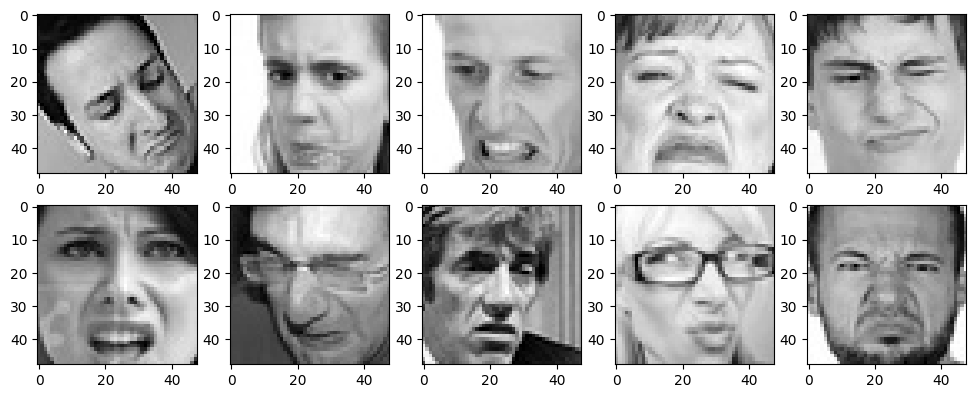

In [47]:
print('Disgust: ')
print()
plot_images(train_dir+'/disgust')

Surprise: 



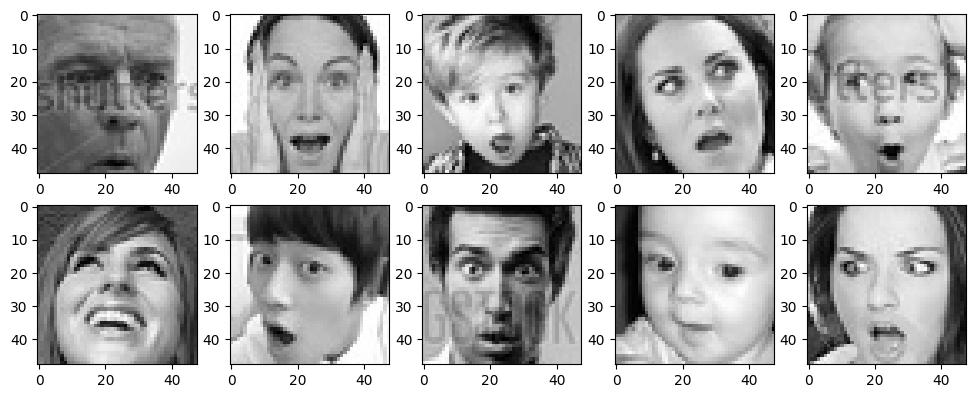

In [50]:
print('Surprise: ')
print()
plot_images(train_dir+'/surprise')

In [5]:
def oversample_by_replication(base_path, threshold_class='happy'):

    # Identify classes
    classes = os.listdir(base_path)

    # Find the maximum number of samples
    max_samples = 0
    for emotion in classes:
        num_samples = len(os.listdir(os.path.join(base_path, emotion)))
        max_samples = max(max_samples, num_samples)

    # Calculate the threshold based on the 'happy' class
    threshold = max_samples

    # Replicate instances for each class
    for emotion in classes:
        source_path = os.path.join(base_path, emotion)
        num_samples = len(os.listdir(source_path))

        # Replicate instances until the threshold is reached
        while num_samples < threshold:
            # Randomly select an instance to replicate
            random_instance = random.choice(os.listdir(source_path))

            # Specify the destination path
            destination_path = os.path.join(base_path, emotion, f'replica_{num_samples}.jpg')

            # Copy the selected instance to the destination
            shutil.copy(os.path.join(source_path, random_instance), destination_path)

            num_samples += 1


oversample_by_replication(train_dir)


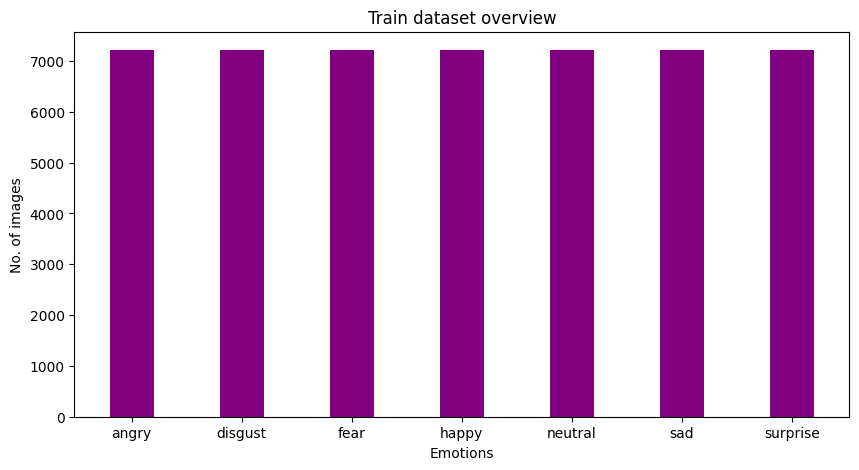

In [7]:
# Data visualisation
emotions = os.listdir(train_dir)
values = [len(os.listdir(f'archive/train/{emotion}')) for emotion in emotions]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(emotions, values, color ='purple',
        width = 0.4)

plt.xlabel("Emotions")
plt.ylabel("No. of images")
plt.title("Train dataset overview")
plt.show()

In [8]:
img_size=48
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 40404 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [8]:
# model = Sequential()

# # Input Layer
# model.add(Conv2D(32, (3, 3), input_shape=(48, 48, 1), activation='relu'))

# # Convolutional layers
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten layer
# model.add(Flatten())

# # Fully connected layers
# model.add(Dense(200, activation='relu'))
# model.add(Dense(7, activation='softmax'))  # Assuming 7 classes for emotions

# # Print model summary
# model.summary()




# # modelCNN = Sequential()
# # modelCNN.add(layers.Conv2D(16,(5,5),padding='valid',input_shape = input_shape)) # Convolutional layers
# # modelCNN.add(layers.Activation('relu')) # activation functions
# # modelCNN.add(layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid')) # to reduce size of image
# # modelCNN.add(layers.Dropout(0.4))

# # modelCNN.add(layers.Conv2D(32,(5,5),padding='valid'))
# # modelCNN.add(layers.Activation('relu'))
# # modelCNN.add(layers.MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
# # modelCNN.add(layers.Dropout(0.6))

# # modelCNN.add(layers.Conv2D(64,(5,5),padding='valid'))
# # modelCNN.add(layers.Activation('relu'))
# # modelCNN.add(layers.Dropout(0.8))

# # modelCNN.add(layers.Flatten())
# # modelCNN.add(layers.Dense(7)) # classification

# # modelCNN.add(layers.Activation('softmax'))

# # modelCNN.summary()

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,3)))
# model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
    
# model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten()) 
# model.add(Dense(256,activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
    
# model.add(Dense(512,activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(7, activation='softmax'))
model=tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)      

In [12]:

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
epochs = 30
batch_size = 64

In [14]:
history = model.fit(x=train_generator, epochs=epochs, validation_data=validation_generator)
history

Epoch 1/30
632/632 [==============================] - 1189s 2s/step - loss: 2.0299 - accuracy: 0.2422 - val_loss: 1.7522 - val_accuracy: 0.3282
Epoch 2/30
632/632 [==============================] - 817s 1s/step - loss: 1.5172 - accuracy: 0.4228 - val_loss: 1.5642 - val_accuracy: 0.4155
Epoch 3/30
632/632 [==============================] - 723s 1s/step - loss: 1.2619 - accuracy: 0.5221 - val_loss: 1.2754 - val_accuracy: 0.5182
Epoch 4/30
632/632 [==============================] - 808s 1s/step - loss: 1.1513 - accuracy: 0.5648 - val_loss: 1.1743 - val_accuracy: 0.5482
Epoch 5/30
632/632 [==============================] - 908s 1s/step - loss: 1.0789 - accuracy: 0.5914 - val_loss: 1.0450 - val_accuracy: 0.6020
Epoch 6/30
632/632 [==============================] - 837s 1s/step - loss: 1.0301 - accuracy: 0.6141 - val_loss: 1.1277 - val_accuracy: 0.5705
Epoch 7/30
632/632 [==============================] - 993s 2s/step - loss: 0.9886 - accuracy: 0.6269 - val_loss: 1.0463 - val_accuracy: 0.611

In [15]:
# # Evaluate the model
cnn_score1 = model.evaluate(validation_generator ) 
print('Test loss: ', cnn_score1[0])
print('Test accuracy: ', cnn_score1[1])
cnn_score2 = model.evaluate(train_generator ) 
print('Train loss: ', cnn_score2[0])
print('Train accuracy: ', cnn_score2[1])

23/23 [==============================] - 8s 351ms/step - loss: 0.9416 - accuracy: 0.6732
Test loss:  0.9416208267211914
Test accuracy:  0.673184335231781
632/632 [==============================] - 227s 358ms/step - loss: 0.4028 - accuracy: 0.8594
Train loss:  0.4027641713619232
Train accuracy:  0.8594198822975159


In [42]:
# Saving the model
model.save('CNNwithbalancing.keras')

In [12]:
dim = (48,48) # for MobileNetV2
n_sequence = 8 # for LSTM
n_channels = 3 # color channel(RGB)
n_output = 7 #18 # number of output class

In [27]:

model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(.5))  
model.add(Dense(n_output, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 1, 48, 48, 3)      0         
                                                                 
 time_distributed_5 (TimeDi  (None, 1, 1, 1, 1280)     2257984   
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 1, 1280)           0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)                344320    
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [28]:
image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
)    

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory=train_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory=test_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )

Found 50505 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [29]:
model.compile(optimizer = "adam",loss = "categorical_crossentropy" , metrics=['accuracy'])
hist = model.fit_generator(training_set, validation_data = testing_set, epochs = 10)


C:\Users\admin\AppData\Local\Temp\ipykernel_6940\523528757.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(training_set, validation_data = testing_set, epochs = 10)


Epoch 1/10
198/198 [==============================] - 249s 1s/step - loss: 1.8374 - accuracy: 0.2452 - val_loss: 1.9319 - val_accuracy: 0.1358
Epoch 2/10
198/198 [==============================] - 222s 1s/step - loss: 1.5679 - accuracy: 0.4084 - val_loss: 2.7917 - val_accuracy: 0.2615
Epoch 3/10
198/198 [==============================] - 216s 1s/step - loss: 1.3919 - accuracy: 0.4859 - val_loss: 1.8148 - val_accuracy: 0.2913
Epoch 4/10
198/198 [==============================] - 211s 1s/step - loss: 1.2886 - accuracy: 0.5255 - val_loss: 2.3638 - val_accuracy: 0.2508
Epoch 5/10
198/198 [==============================] - 211s 1s/step - loss: 1.2280 - accuracy: 0.5494 - val_loss: 2.2394 - val_accuracy: 0.2717
Epoch 6/10
198/198 [==============================] - 226s 1s/step - loss: 1.1784 - accuracy: 0.5676 - val_loss: 1.8492 - val_accuracy: 0.4244
Epoch 7/10
198/198 [==============================] - 219s 1s/step - loss: 1.1362 - accuracy: 0.5836 - val_loss: 1.8583 - val_accuracy: 0.4042

In [32]:
training_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']

# Print the final accuracy values
print("Final Training Accuracy:", training_accuracy[-1])
print("Final Validation Accuracy:", validation_accuracy[-1])

Final Training Accuracy: 0.6187704205513
Final Validation Accuracy: 0.419058233499527


In [35]:
model.save("mobilenet.keras")

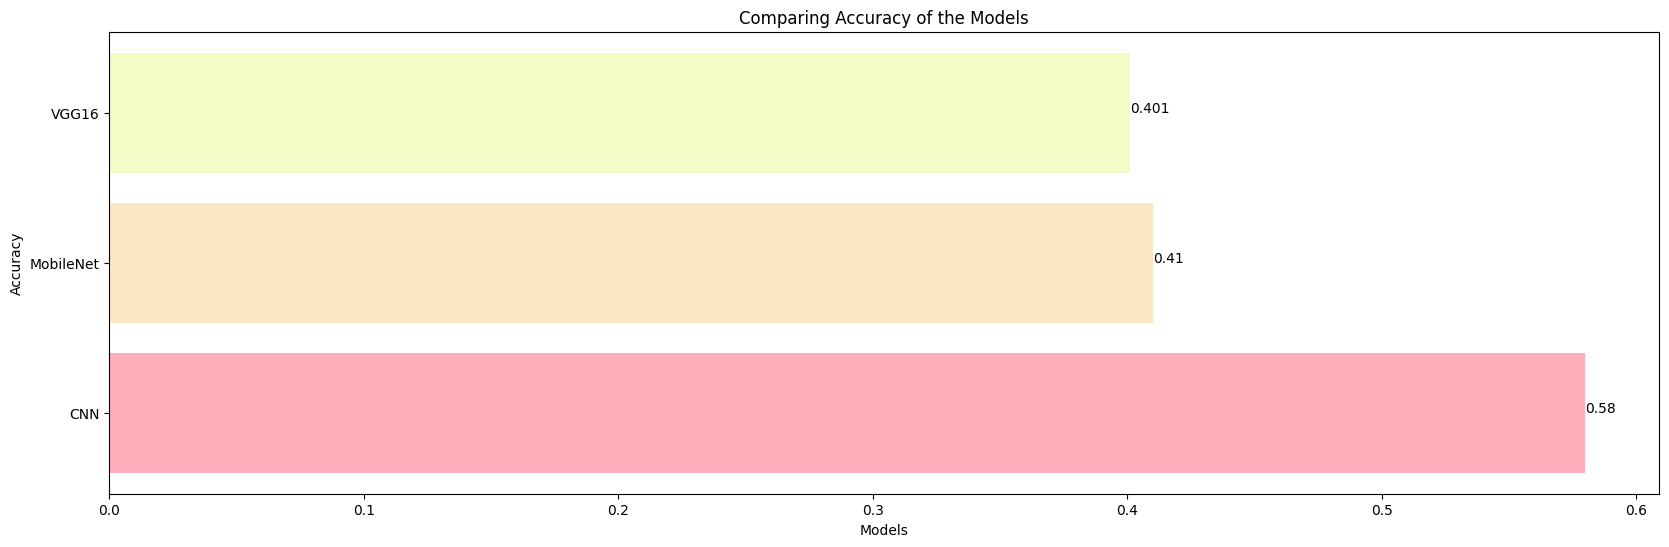

In [4]:
names = ['CNN', 'MobileNet','VGG16']
compare_acc = [0.58, 0.41,0.4010]
plt.figure(figsize=(20,6))


plt.barh(names,compare_acc, color=['#FFAEBC', '#FBE7C6','#f5fbc6'])
for index, value in enumerate(compare_acc):
    plt.text(value, index, str(value))
plt.title('Comparing Accuracy of the Models')
plt.ylabel('Accuracy')
plt.xlabel('Models')

plt.show()